In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
from tf_utils import *
# We also need PrettyTensor.
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [15]:
tf.keras.__version__

'2.0.8-tf'

In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [37]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [16]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10
img_shape_full=(img_size,img_size,1)

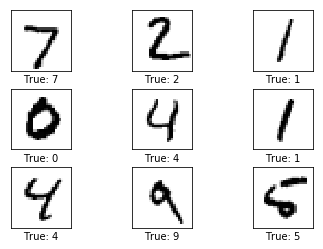

In [11]:
images=data.test.images[:9]
cls_true=data.test.cls[:9]
plot_images(images=images,cls_true=cls_true,img_shape=img_shape)

In [19]:
model=Sequential()
model.add(InputLayer(input_shape=(img_size_flat,)))
model.add(Reshape(img_shape_full))
model.add(Conv2D(kernel_size=5,strides=1,filters=16,padding='same',activation='relu',
                name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2,strides=2))

model.add(Conv2D(kernel_size=5,strides=1,filters=36,padding='same',activation='relu',
                name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2,strides=2))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

In [20]:
from tensorflow.python.keras.optimizers import Adam
optimizer=Adam(lr=1e-3)

In [22]:
model.compile(optimizer,loss='categorical_crossentropy',metrics=['accuracy'])


model.fit(x=data.train.images,
        y=data.train.labels,
        epochs=1,
        batch_size=128)

Epoch 1/1
55000/55000 [==============================] - 12s - loss: 0.2111 - acc: 0.9392    


In [23]:
result=model.evaluate(x=data.test.images,
                      y=data.test.labels)

 9984/10000 [============================>.] - ETA: 0s

In [25]:
for name, value in zip(model.metrics_names,result):
    print(name, value)

loss 0.059926409448310736
acc 0.9811


In [26]:
model.metrics_names

['loss', 'acc']

In [27]:
result

[0.059926409448310736, 0.9811]

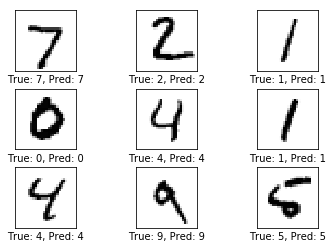

In [30]:
images=data.test.images[:9]
cls_true=data.test.cls[:9]
y_pred=model.predict(x=images)
cls_pred=np.argmax(y_pred, axis=1)
plot_images(
    images,
    cls_true,
    (28,28),
    cls_pred
)

In [47]:
y_pred = model.predict(x=data.test.images)
cls_pred=np.argmax(y_pred,axis=1)
cls_pred==data.test.cls

array([ True,  True,  True, ...,  True,  True,  True])

In [50]:
def plot_example_errors(cls_pred):
    incorrect = (cls_pred!=data.test.cls)
    images = data.test.images[incorrect]   
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                img_shape=img_shape,
                cls_pred=cls_pred[0:9])

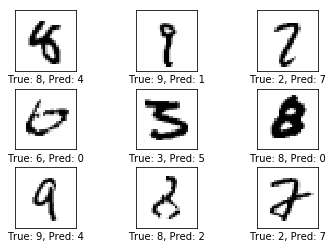

In [51]:
plot_example_errors(cls_pred)

In [55]:
# functional model

inputs = Input(shape=(img_size_flat,))
net = inputs

net = Reshape(img_shape_full)(net)
net = Conv2D(kernel_size=5,strides=1,filters=16,padding='same',
                activation='relu',
                name='layer_conv1')(net)
net = MaxPooling2D(pool_size=2,strides=2)(net)

net = Conv2D(kernel_size=5,strides=1,filters=36,padding='same',
                activation='relu',
                name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2,strides=2)(net)

net = Flatten()(net)
net = Dense(128,activation='relu')(net)
net = Dense(num_classes, activation='softmax')(net)

outputs = net

In [57]:
from tensorflow.python.keras.models import Model

model2 = Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer='adadelta',loss='categorical_crossentropy',metrics=['accuracy'])
model2.fit(x=data.train.images,
           y=data.train.labels,
           epochs=1,
           batch_size=128) 

Epoch 1/1
55000/55000 [==============================] - 9s - loss: 0.2926 - acc: 0.9127     


In [59]:
result = model2.evaluate(x=data.test.images, y=data.test.labels)

 9536/10000 [===========================>..] - ETA: 0s

In [60]:
model2.metrics_names, result

(['loss', 'acc'], [0.07406330580431968, 0.974])

In [61]:
path = 'model.pt'
model2.save(path)

In [63]:
from tensorflow.python.keras.models import load_model

In [64]:
model3=load_model(path)
model3.evaluate(x=data.test.images, y=data.test.labels)

 9760/10000 [============================>.] - ETA: 0s

[0.07406330580431968, 0.974]

In [65]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1764)              0         
__________